In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
%matplotlib notebook

In [4]:
import smib_milano_ex8p1_avr

In [5]:
syst = smib_milano_ex8p1_avr.smib_milano_ex8p1_avr_class()
x0 = np.ones(syst.N_x+syst.N_y)
s = sopt.fsolve(syst.run_problem,x0 )
print(s)

[6.38358477 1.         1.45906524 0.05832752 0.98056764 0.98056764
 0.01088214 0.08766061 0.97664145 1.60755383 0.05254731 0.2
 0.19223903 1.56539738 3.88647153]


In [6]:
syst.struct[0]['x']

array([[6.38358477],
       [1.        ],
       [1.45906524],
       [0.05832752],
       [0.98056764]])

In [7]:
syst.struct[0]['y']

array([[0.98056764],
       [0.01088214],
       [0.08766061],
       [0.97664145],
       [1.60755383],
       [0.05254731],
       [0.2       ],
       [0.19223903],
       [1.56539738],
       [3.88647153]])

In [13]:
run = smib_milano_ex8p1_avr.run
@numba.njit(cache=True) 
def perturbations(t,struct): 
    
    struct[0].v_ref = 1.0
    if t>1.0: struct[0].v_ref= 1.02
    return

        
@numba.njit(cache=True) 
def solver(struct): 
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    i = 0 
    
    Dt = struct[i].Dt 
    N_steps = struct[i].N_steps 
    N_store = struct[i].N_store 
    N_x = struct[i].N_x
    N_y = struct[i].N_y
    N_outs = 1 
    decimation = struct[i].decimation 
    eye = np.eye(N_x)
    # initialization 
    #t = struct[i].t 
    t = 0.0
    run(0.0,struct, 1) 
    it_store = 0 
    struct[i]['T'][0] = t 
    struct[i].X[0,:] = struct[i].x[:,0]  
    
    Y = np.zeros((N_store,N_y))

    

    Y[0,:] = struct[i].y[:,0]  
 
    solver = struct[i].solvern 
    for it in range(N_steps-1): 
        t += Dt 
 
        perturbations(t,struct) 
        
        if solver == 1: 
            # forward euler solver  
            run(t,struct, 2)  
            struct[i].x[:] += Dt*struct[i].f  
 
        if solver == 2: 
            
            # bacward euler solver
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct, 10)  
                phi =  x_0 + Dt*struct[i].f - struct[i].x 
                Dx = np.linalg.solve(-(Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                if np.max(np.abs(Dx)) < struct[i].itol: break 
            print(struct[i].f)
 
        if solver == 3: 
            # trapezoidal solver
            run(t,struct, 2) 
            f_0 = np.copy(struct[i].f[:]) 
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 10)  
                phi =  x_0 + 0.5*Dt*(f_0 + struct[i].f) - struct[i].x 
                Dx = np.linalg.solve(-(0.5*Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                run(t,struct, 2) 
                if np.max(np.abs(Dx)) < struct[i].itol: break 

        if solver == 4: 
            #print(t)
            run(t,struct, 2) 
            run(t,struct, 3) 

            x = np.copy(struct[i].x[:]) 
            y = np.copy(struct[i].y[:]) 
            f = np.copy(struct[i].f[:]) 
            g = np.copy(struct[i].g[:]) 
            
            for iter in range(1):
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct,10) 
                run(t,struct,11) 
                
                x_i = struct[i].x[:] 
                y_i = struct[i].y[:]  
                f_i = struct[i].f[:] 
                g_i = struct[i].g[:]                 
                F_x_i = struct[i].Fx[:,:]
                F_y_i = struct[i].Fy[:,:] 
                G_x_i = struct[i].Gx[:,:] 
                G_y_i = struct[i].Gy[:,:]                

                A_c_i = np.vstack((np.hstack((eye-0.5*Dt*F_x_i, -0.5*Dt*F_y_i)),
                                   np.hstack((G_x_i,         G_y_i))))
                     
                f_n_i = x_i - x - 0.5*Dt*(f_i+f) 
                #print(t,iter,np.linalg.det(G_y_i),struct[i].x[1,0])
                Dxy_i = np.linalg.solve(-A_c_i,np.vstack((f_n_i,g_i))) 
                
                x_i = x_i + Dxy_i[0:N_x]
                y_i = y_i + Dxy_i[N_x:(N_x+N_y)]

                struct[i].x[:] = x_i
                struct[i].y[:] = y_i

                if np.max(np.abs(Dxy_i[:,0]))<1.0e-6:
                    
                    break


                
        # channels 
        if it >= it_store*decimation: 
            struct[i]['T'][it_store+1] = t 
            struct[i].X[it_store+1,:] = struct[i].x[:,0] 
            Y[it_store+1,:] = struct[i].y[:,0]
            it_store += 1 
    struct[i].t = t
    return struct[i]['T'][:], struct[i].X[:], Y 


In [14]:
syst.solvern = 4

syst.t_end = 15.0
syst.Dt = 0.010
syst.decimation =1
syst.update()


#syst.struct[0].H = 5
#syst.struct[0].T_pss_1 = 3.6415847004537487              
#syst.struct[0].T_pss_2 = 0.6398979816027691 
#syst.struct[0].D = x_pso[1]
x0 = np.ones((syst.N_x+syst.N_y,1))
x0[0] =0
s = sopt.fsolve(syst.run_problem,x0 )
syst.struct[0].x[:,0] = s[0:syst.N_x]
syst.struct[0].y[:,0] = s[syst.N_x:]


In [15]:
s

array([0.10039946, 1.        , 1.45906524, 0.05832751, 0.98056764,
       0.98056764, 0.01088214, 0.0876606 , 0.97664145, 1.60755384,
       0.05254731, 0.2       , 0.19223903, 1.56539738, 3.88647154])

In [16]:
T,X,Y = solver(syst.struct)




<IPython.core.display.Javascript object>


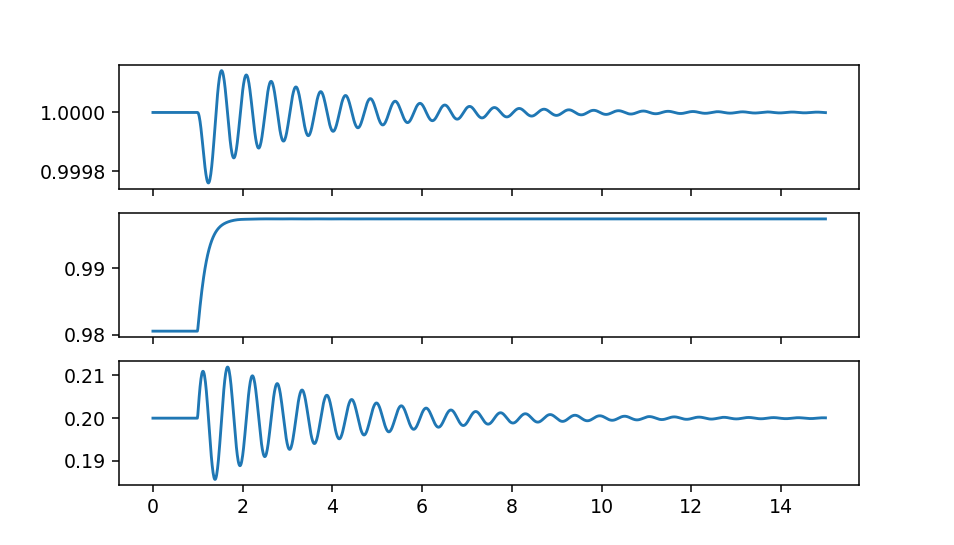

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex = True)
axes[0].plot(T[:-1], X[:-1,1])
axes[1].plot(T[:-1], Y[:,0])
axes[2].plot(T[:-1], Y[:,6])

<IPython.core.display.Javascript object>


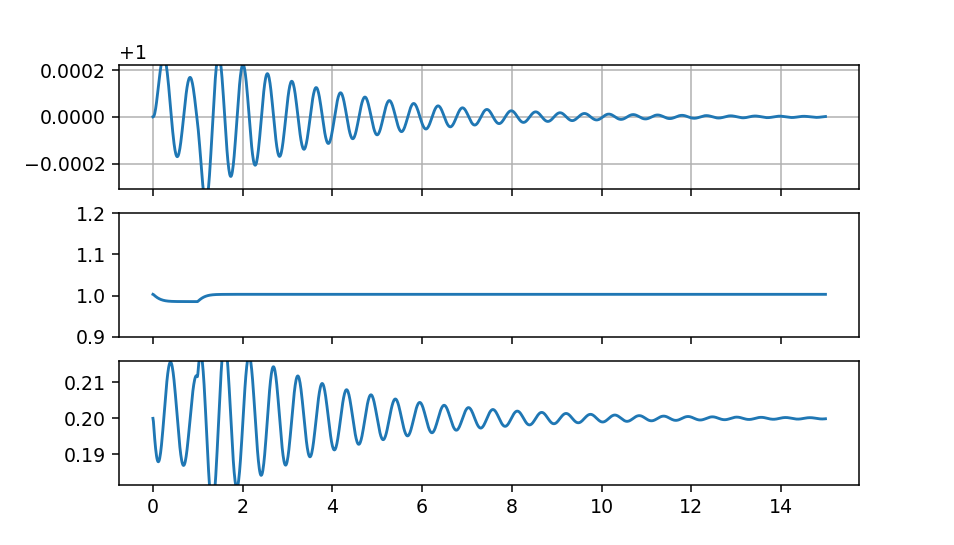

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex = True)

x0 = np.ones((syst.N_x+syst.N_y,1))
x0[0] =0
s = sopt.fsolve(syst.run_problem,x0 )
syst.struct[0].x[:,0] = s[0:syst.N_x]
syst.struct[0].y[:,0] = s[syst.N_x:]

T,X,Y = solver(syst.struct)


curve_1 = axes[0].plot(T[:-1], X[:-1,1])
curve_2 = axes[1].plot(T[:-1], Y[:,0])
curve_3 = axes[2].plot(T[:-1], Y[:,6])

axes[1].set_ylim([0.9,1.2])
#axes[0].set_xlim([0,15])
axes[0].grid(True)
fig.canvas.draw()

def update(K_a = 200.0):
    syst.struct[0].K_a = K_a 
    x0 = np.ones((syst.N_x+syst.N_y,1))
    x0[0] =0
    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
          
    T,X,Y = solver(syst.struct)
    curve_1[0].set_xdata(T[:-1])
    curve_2[0].set_xdata(T[:-1])
    curve_3[0].set_xdata(T[:-1])
    curve_1[0].set_ydata(X[:-1,1])
    curve_2[0].set_ydata(Y[:,0])
    curve_3[0].set_ydata(Y[:,6])    

    fig.canvas.draw()
update()

In [31]:
interact(update, 
         K_a =widgets.FloatSlider(min=1.0,max=300,step=0.1,value=200.0, continuous_update=False),
        );

interactive(children=(FloatSlider(value=200.0, continuous_update=False, description='K_a', max=300.0, min=1.0)…

In [40]:
Fx = syst.struct[0].Fx
Fy = syst.struct[0].Fy
Gx = syst.struct[0].Gx
Gy = syst.struct[0].Gy   
A = Fx - Fy @ np.linalg.inv(Gy) @ Gx
eig,eigv = np.linalg.eig(A)

<IPython.core.display.Javascript object>


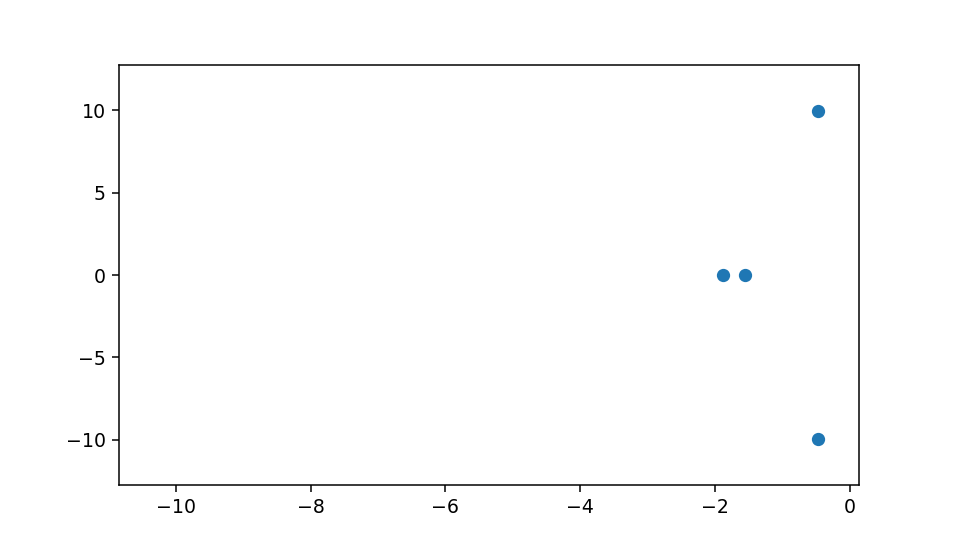

[-0.0328848 -0.0328848 -1.        -1.        -1.       ]


In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex = True)
curve_1 = axes.plot(eig.real,eig.imag,'o')

def update_ka(K_a = 200.0):
    syst.struct[0].K_a = K_a 
    x0 = np.ones((syst.N_x+syst.N_y,1))
    x0[0] =0
    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    Fx = syst.struct[0].Fx
    Fy = syst.struct[0].Fy
    Gx = syst.struct[0].Gx
    Gy = syst.struct[0].Gy   
    A = Fx - Fy @ np.linalg.inv(Gy) @ Gx
    eig,eigv = np.linalg.eig(A)
    omegas = eig.imag
    sigmas = eig.real

    freqs = omegas/(2*np.pi)
    zetas = sigmas/np.sqrt(sigmas**2+omegas**2)
    curve_1[0].set_xdata(eig.real)
    curve_1[0].set_ydata(eig.imag)
    
    fig.canvas.draw()
    print(zetas)
update()


In [53]:
interact(update_ka, 
         K_a =widgets.FloatSlider(min=1.0,max=300,step=0.1,value=200.0, continuous_update=False),
        );

interactive(children=(FloatSlider(value=200.0, continuous_update=False, description='K_a', max=300.0, min=1.0)…